# Group 14 - Project FP01
## Time series anomaly detection - XGBoost

This project aims at investigating the current state-of-the-arts TAD scenario using XGBoost.

In [ ]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install xgboost
# !pip install -U kaleido

In [1]:
import os
import time
import tsfel
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from dataset import get_df_action, get_features_ts, get_train_test_data
from plots import plot_anomalies, plot_anomalies_over_time, plot_roc_curve
from metrics import compute_metrics

# Set style for matplotlib
plt.style.use("Solarize_Light2")

2024-07-15 15:16:24.402971: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-15 15:16:24.933149: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 15:16:24.933263: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 15:16:24.935013: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 15:16:25.139424: I tensorflow/core/platform/cpu_feature_g

In [2]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL = '../../dataset/normal'
ROOTDIR_DATASET_ANOMALY = '../../dataset/collisions'

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Data Loading and Preprocessing

In [3]:
freq = '0.1'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

# COLLISION DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Extraction

In [4]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 90.20395803451538 seconds ---


In [14]:
X_train, y_train, X_test, y_test = get_train_test_data(df_features, df_features_collision, full_normal=True)

#X_normal, _, X_anomaly, y_anomaly = get_train_test_data(df_features, df_features_collision, full_normal=True)

# Combine normal and anomaly data for testing
#X_test = pd.concat([X_normal, X_anomaly])
#y_test = np.concatenate([np.zeros(len(X_normal)), np.ones(len(X_anomaly))])

# Use only normal data for training
#X_train = X_normal.copy()

# Standardize the features
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

#print(f"Training data shape: {X_train_scaled.shape}")
#print(f"Testing data shape: {X_test_scaled.shape}")

X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (306, 2200)
y_test shape: (306,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (306, 96)
y_test shape: (306,)


## XGBoost for Anomaly Detection

In [17]:
# Initialize and train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

print("XGBoost training completed.")

XGBoost training completed.


### Anomaly Detection

Anomaly prediction completed.


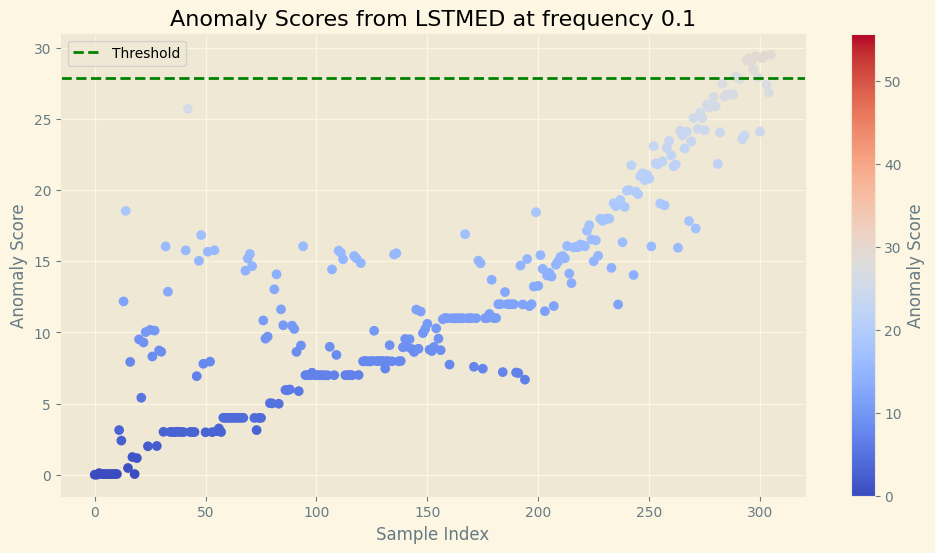

Number of anomalies detected: 11


(array([4.44645155e-03, 5.21688117e-03, 1.18040398e-01, 5.30707315e-02,
        5.15167527e-02, 5.15167527e-02, 4.94160876e-02, 5.01865186e-02,
        5.15167527e-02, 5.15167527e-02, 5.15167527e-02, 3.14089251e+00,
        2.40238738e+00, 1.21808453e+01, 1.85466175e+01, 4.76770431e-01,
        7.93063259e+00, 1.24809992e+00, 5.15748858e-02, 1.17145777e+00,
        9.51542759e+00, 5.41403389e+00, 9.29648018e+00, 1.00297632e+01,
        2.00466514e+00, 1.01826973e+01, 8.31192303e+00, 1.01283875e+01,
        2.02324247e+00, 8.73580360e+00, 8.64286518e+00, 3.01883054e+00,
        1.60462837e+01, 1.28635159e+01, 3.00972104e+00, 3.00501060e+00,
        2.99986529e+00, 3.02565813e+00, 3.01186419e+00, 3.01381922e+00,
        2.99995136e+00, 1.57687054e+01, 2.57107849e+01, 3.00680757e+00,
        3.00288033e+00, 3.00439143e+00, 6.92896843e+00, 1.50368204e+01,
        1.68440952e+01, 7.79793882e+00, 2.98846483e+00, 1.56726713e+01,
        7.94869280e+00, 2.99807096e+00, 1.57741137e+01, 3.062278

In [18]:
#def compute_reconstruction_error(model, X):
#    X_pred = model.predict(X)
#    mse = np.mean(np.power(X - X_pred, 2), axis=1)
#    return mse

# Compute reconstruction error for test data
#anomaly_scores = compute_reconstruction_error(xgb_model, X_test_scaled)

# Plot anomalies
#threshold = np.mean(anomaly_scores) + 2 * np.std(anomaly_scores)
plot_anomalies(xgb_model, X_test, y_test, freq)

In [19]:
# Compute metrics
anomaly_scores, y_test_binary = compute_metrics(xgb_model, X_test, y_test)
#metrics = compute_metrics(y_test, anomaly_scores, threshold)
#print("Anomaly Detection Metrics:")
#for metric, value in metrics.items():
#    print(f"{metric}: {value:.4f}")

Anomaly scores statistics:
Mean: 12.748700141906738
Std: 7.561588287353516
Min: 0.004446451552212238
Max: 29.515151977539062
ROC AUC Score: 0.9900
Detected anomaly class: 29
Threshold: 27.8719
F1 Score: 0.7059
Accuracy: 0.9837
Precision: 0.5455
Recall: 1.0000
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       300
           1       0.55      1.00      0.71         6

    accuracy                           0.98       306
   macro avg       0.77      0.99      0.85       306
weighted avg       0.99      0.98      0.99       306



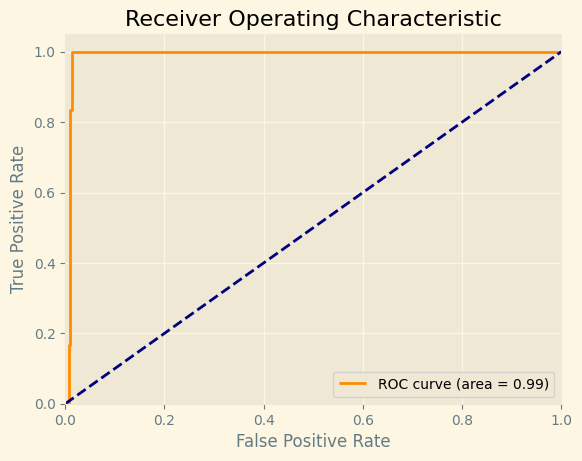

In [22]:
plot_roc_curve(y_test_binary, anomaly_scores)

## Map anomalies to original time series

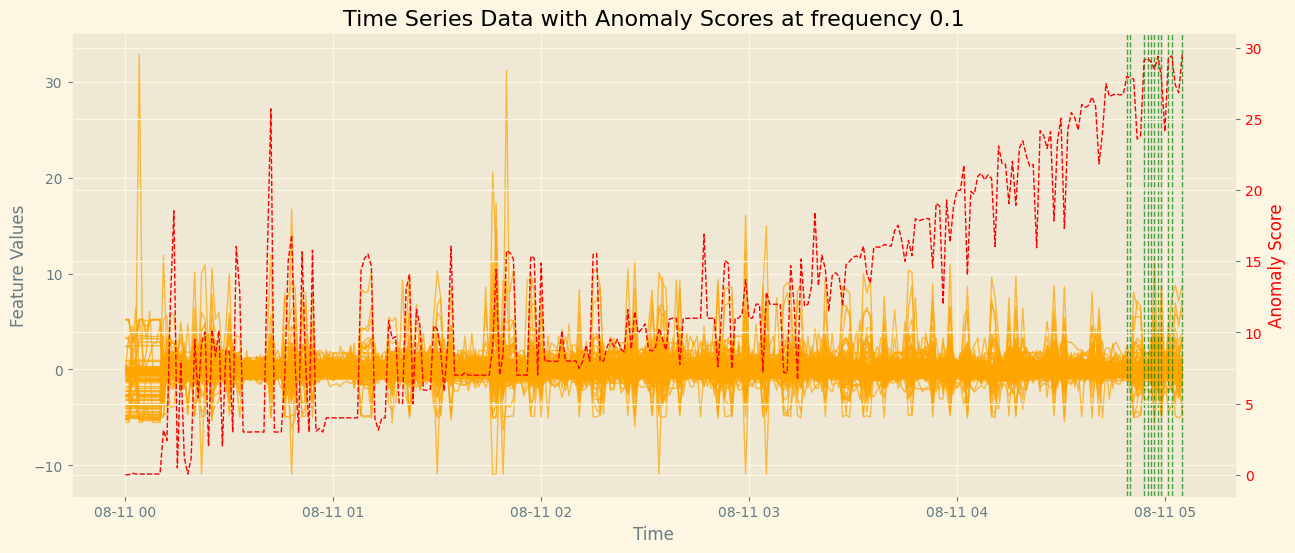

Top 11 Anomalies:
              timestamp  anomaly_score  \
305 2022-08-11 05:05:00      29.515152   
302 2022-08-11 05:02:00      29.437784   
298 2022-08-11 04:58:00      29.402615   
301 2022-08-11 05:01:00      29.270079   
295 2022-08-11 04:55:00      29.258459   
294 2022-08-11 04:54:00      29.123205   
296 2022-08-11 04:56:00      29.024734   
297 2022-08-11 04:57:00      28.500607   
289 2022-08-11 04:49:00      27.980213   
299 2022-08-11 04:59:00      27.929159   
290 2022-08-11 04:50:00      27.886646   

     machine_nameKuka Robot_apparent_power-_Average power  \
305                                          -1.455966      
302                                          -0.518975      
298                                          -0.524594      
301                                          -0.860780      
295                                           0.060507      
294                                          -0.267430      
296                                           0.55

In [23]:
plot_anomalies_over_time(X_test, anomaly_scores, sum(anomaly_scores > np.mean(anomaly_scores) + 2 * np.std(anomaly_scores)), freq)

## Feature Importance Analysis

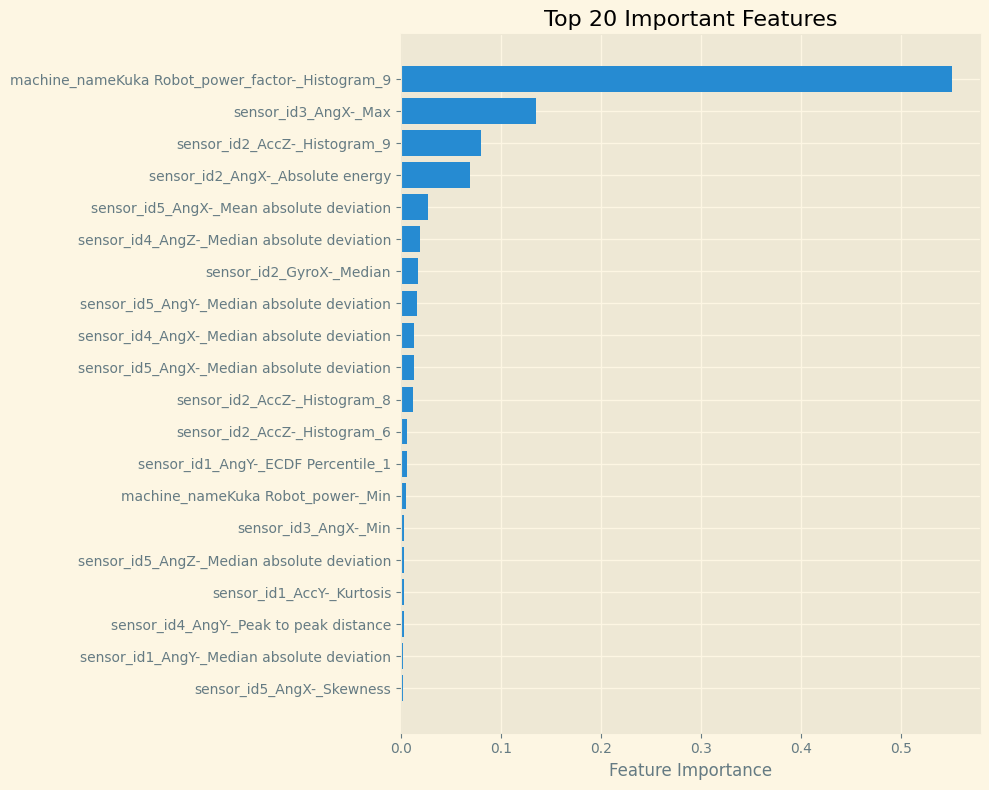

In [24]:
feature_importance = xgb_model.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_idx = np.argsort(feature_importance)
sorted_features = feature_names[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

# Plot top 20 features
plt.figure(figsize=(10, 8))
plt.barh(range(20), sorted_importance[-20:])
plt.yticks(range(20), sorted_features[-20:])
plt.xlabel('Feature Importance')
plt.title('Top 20 Important Features')
plt.tight_layout()
plt.show()